# Transformations Example Notebook
## "Explain Me This: Salience-Based Explainability for Synthetic Face Detection Models"
### by ****, 1/31/23

In [120]:
import os
import cv2
import glob
import random
import pickle
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import argparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms

/home/ccrum/Downloads/enter/envs/cyborg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Necessary Arguments

In [121]:
parser = argparse.ArgumentParser()
# dummy argument to work in Jupyter Notebook instead of command line
parser.add_argument('-f')
parser.add_argument('-mp', '--modelPath', default="../../Models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth", type=str)
parser.add_argument('-n', '--network', default="densenet", type=str)
parser.add_argument('-d', '--dataset', default="../../Data/images/ffhq_aligned/00001.png", type=str)
parser.add_argument('-t', '--type', default="blur")
parser.add_argument('-w', '--where', default="background")
parser.add_argument('-gc', '--gradcam', default="gradcam", type=str)

args = vars(parser.parse_args())

In [122]:
device = torch.device('cpu')

## Loading in the model

In [123]:
# Load weights of single binary DesNet121 model
weights = torch.load(args["modelPath"], map_location=device)

if args["network"] == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()
sigmoid = nn.Sigmoid()

## Preprocessing

In [124]:
if args["network"] == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

## Geometrical Transformations

In [125]:
transformations = {
    'x-16_y-16':[32,256,32,256],
    'x-16_y0':[16,240,32,256],
    'x-16_y16':[0,224,32,256],
    'x0_y-16':[32,256,16,240],
    'x0_y16':[0,224,16,240],
    'x16_y-16':[32,256,0,224],
    'x16_y0':[16,240,0,224],
    'x16_y16':[0,224,0,224],
}

## Loading in the input image

In [126]:
image_file = args['dataset']

## Performing LR and TB transformations

In [127]:
# for display purposes
augmented_images = []

# Original Image
img_orig = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Left Right
img_lr_UPR = cv2.flip(cv2.imread(image_file, cv2.IMREAD_UNCHANGED), 1)
img_lr_UPR = cv2.cvtColor(img_lr_UPR, cv2.COLOR_BGR2RGB)

# Top Bottom
img_tb_UPR = cv2.flip(cv2.imread(image_file, cv2.IMREAD_UNCHANGED), 0)
img_tb_UPR = cv2.cvtColor(img_tb_UPR, cv2.COLOR_BGR2RGB)

# adding images to list for later viewing
augmented_images.append(img_orig)
augmented_images.append(img_lr_UPR)
augmented_images.append(img_tb_UPR)

## Geometric transformations

In [128]:
for shifts in transformations:
    im_exp = cv2.copyMakeBorder(cv2.imread(image_file, cv2.IMREAD_UNCHANGED), 16, 16, 16, 16, cv2.BORDER_REPLICATE)
    yyxx = transformations[shifts]
    trans_image = im_exp[yyxx[0]:yyxx[1],yyxx[2]:yyxx[3]]
    trans_image = cv2.cvtColor(trans_image, cv2.COLOR_BGR2RGB)
    # adding images to list for later viewing
    augmented_images.append(trans_image)

## Clockwise and Counterclock wise transformations

In [129]:
img_left90_UPR = cv2.rotate(cv2.imread(image_file, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_CLOCKWISE)
img_left90_UPR = cv2.cvtColor(img_left90_UPR, cv2.COLOR_BGR2RGB)

img_right90_UPR = cv2.rotate(cv2.imread(image_file, cv2.IMREAD_UNCHANGED), cv2.ROTATE_90_COUNTERCLOCKWISE)
img_right90_UPR = cv2.cvtColor(img_right90_UPR, cv2.COLOR_BGR2RGB)

augmented_images.append(img_left90_UPR)
augmented_images.append(img_right90_UPR)

## Getting Predictions from Model

In [133]:
predictions = []

for image in augmented_images:
    # Model Preprocessing
    image = Image.fromarray(image)
    tranformImage = transform(image)
    tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
    tranformImage = tranformImage.to(device)

    # Get Prediction From Model
    with torch.no_grad():
        output = model(tranformImage)

    PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
    predictions.append(PAScore)

## Displaying Image Transformations

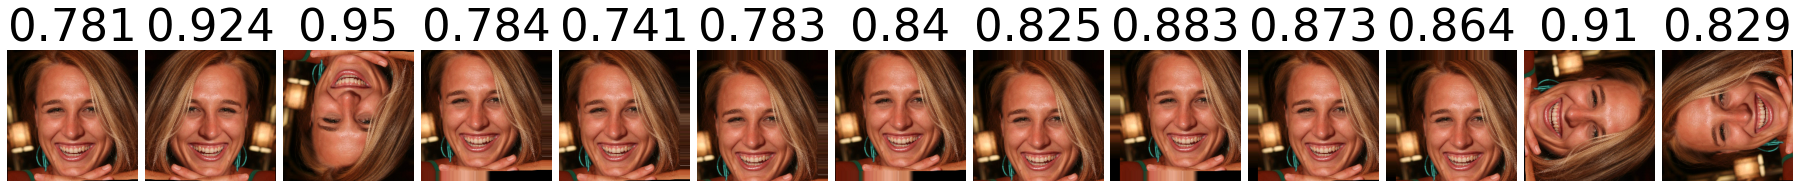

In [134]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 13),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )
for index, (ax, im) in enumerate(zip(grid, augmented_images)):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()